# Modelo para clasificación galaxias-estrellas basado en ResNet

## Preparar la data

### Montamos el drive y las librerias

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers as tfl, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import cv2
import sys
from tensorflow.keras.utils import to_categorical
import os

### Montamos todas las imagenes en formato array y le añadimos una etiqueta de clasificación previa

In [68]:
data = []
labels =[]
import glob
csv_path = '/content/drive/MyDrive/RedNeuronal_ResNet/DataSet_SSDLimpio/class.csv'
img_dir = '/content/drive/MyDrive/RedNeuronal_ResNet/DataSet_SSDLimpio/dataset/'
file_list = os.listdir(img_dir)
# for file_name in os.listdir(img_path):
#     ruta_imagen = os.path.join(img_dir, file_name)
#     imagen = cv2.imread(ruta_imagen)
#     data.append(imagen)
#     labels.append(0)


In [69]:
coords = pd.DataFrame(pd.read_csv(csv_path))
coords['file_name'] = coords.pop('0')
coords['class'] = coords.pop('1')
coords['images'] = ''
coords

,file_name,class,images
0,imagen_1.jpg,Star,
1,imagen_2.jpg,Galaxy,
2,imagen_3.jpg,Galaxy,
3,imagen_4.jpg,Galaxy,
4,imagen_5.jpg,Star,
...,...,...,...
1053,imagen_1054.jpg,Star,
1054,imagen_1055.jpg,Galaxy,
1055,imagen_1056.jpg,Galaxy,
1056,imagen_1057.jpg,Galaxy,


In [70]:
for index,row in coords.iterrows():
  file_name = row['file_name']
  labels.append(row['class'])
  img_path = os.path.join(img_dir,file_name)
  img = cv2.imread(img_path)
  #img = cv2.bitwise_not(img)
  row['images'] = img
  data.append(img)

In [ ]:
def re_label(row):
  if row['labels'] == 'Star':
    return 0
  else:
    return 1

In [71]:
for i in range(len(labels)):
  if labels[i] == 'Star':
    labels[i] = 0
  else:
    labels[i] = 1


In [72]:
data, labels= np.array(data), np.array(labels)

In [73]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

### Separamos el data set en data de entrenamiento y prueba

In [74]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, test_size=0.5,
                                                random_state=42, shuffle=True)

In [75]:
y_train, y_valid = to_categorical(y_train),  to_categorical(y_valid)

### Revisamos que la data esté correcta




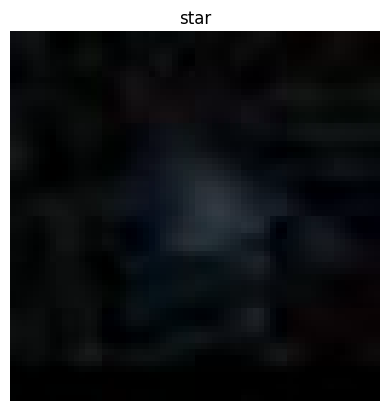

In [51]:
def show_img(x, y, index):
    plt.imshow(x[index])
    if y[index]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    plt.axis('off')
    plt.show()

show_img(x_test, y_test, 6)

## Construimos Modelo ResNet

### Construimos las funciones de bloques del modelo

Estos los vamos a utilizar cuando creemos la arquitectura del modelo

Función de bloque de identidad

In [52]:
def identity_block(input_img, filters):
    x_img= input_img


    #layer 1
    conv11 = tfl.Conv2D(filters, kernel_size=3, padding='same')(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)

    #layer 2
    conv21 = tfl.Conv2D(filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)

    # adding layers
    x_add = tfl.Add()([x_img, batch21])
    x_identity = tfl.Activation('relu')(x_add)

    return x_identity

Función de bloque Convolucional

In [53]:
def conv_block(input_img, filters):
    x_img = input_img

    #layer 1
    conv11 = tfl.Conv2D( filters, kernel_size=3, padding='same', strides=2)(x_img)
    batch11 = tfl.BatchNormalization()(conv11)
    act11 = tfl.Activation('relu')(batch11)

    #layer 2
    conv21 = tfl.Conv2D( filters, kernel_size= 3, padding='same')(act11)
    batch21 = tfl.BatchNormalization()(conv21)

    #conv block layer
    conv_blk = tfl.Conv2D( filters, kernel_size= 1, strides=2)(x_img)

    # adding layers
    x_add = tfl.Add()([batch21, conv_blk])
    x_conv = tfl.Activation('relu')(x_add)

    return x_conv

### Construimos arquitectura de red

In [54]:
def resnet_model(classes, shape=(256,256,3)):

    x= tfl.Input(shape)
    x_rescaled = tfl.Rescaling(scale=1./255)(x)
    #base layer
    c1= tfl.Conv2D(64, kernel_size=7, strides=2, padding='same')(x_rescaled)
    b1= tfl.BatchNormalization()(c1)
    a1= tfl.Activation('relu')(b1)
    pool1= tfl.MaxPool2D(strides=(2,2), pool_size=3)(a1)

    # 1st identity block
    iden_layer1 = identity_block(pool1, 64)
    iden_layer2 = identity_block(iden_layer1, 64)
    iden_layer3 = identity_block(iden_layer2, 64)

    # 1st convolutional block
    conv_layer1 = conv_block(iden_layer3, 128)

    # 2nd identity block
    iden_layer1 = identity_block(conv_layer1, 128)
    iden_layer2 = identity_block(iden_layer1, 128)
    iden_layer3 = identity_block(iden_layer2, 128)

    # 2nd convolutional block
    conv_layer1 = conv_block(iden_layer3, 256)

    # 3rd identity block
    iden_layer1 = identity_block(conv_layer1, 256)
    iden_layer2 = identity_block(iden_layer1, 256)
    iden_layer3 = identity_block(iden_layer2, 256)
    iden_layer4 = identity_block(iden_layer3, 256)
    iden_layer5 = identity_block(iden_layer4, 256)

    # 3rd convolutional block
    conv_layer1 = conv_block(iden_layer5, 512)

    # 4th identity block
    iden_layer1 = identity_block(conv_layer1, 512)
    iden_layer2 = identity_block(iden_layer1, 512)

    # final layer

    avg_pool = tfl.AveragePooling2D((2,2), padding='same' )(iden_layer2)
    flat = tfl.Flatten()(avg_pool)
    d1 = tfl.Dense(1024, activation = 'relu')(flat)
    d2 = tfl.Dense(classes, activation='softmax')(d1)
    model = tf.keras.models.Model(inputs= x, outputs= d2, name='RESNET34_ARCH')

    return model

In [55]:
model = resnet_model(2,(64,64,3))

In [56]:
model.summary()

Model: "RESNET34_ARCH"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 32, 32, 64)   9472        ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization_33 (BatchN  (None, 32, 32, 64)  256         ['conv2d_36[0][0]']              
 ormalization)                                                                        

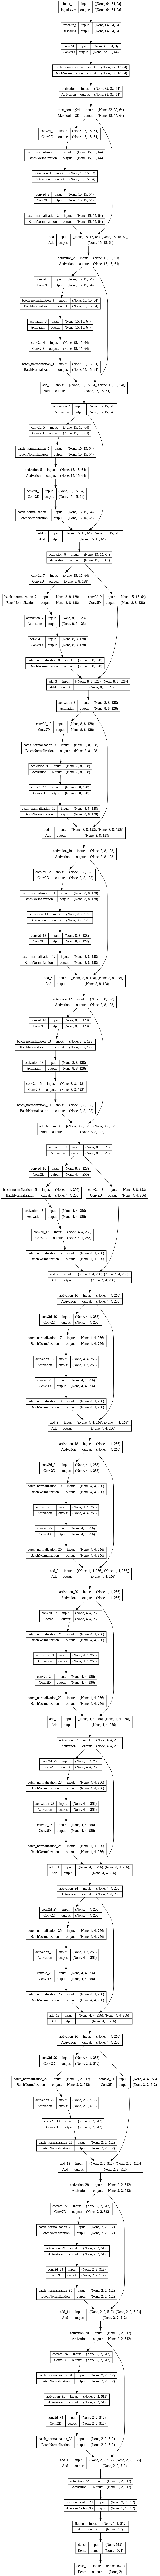

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [85]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [86]:
model.compile(optimizer= optimizers.Adam(learning_rate=0.01),
             loss='categorical_crossentropy',
                    metrics=METRICS)

In [87]:
checkpoint_path = '/content/drive/MyDrive/RedNeuronal_ResNet/modelsV4/checkpoints/'
saved_model_path = '/content/drive/MyDrive/RedNeuronal_ResNet/modelsV4/saved_model/'

In [88]:
# simple early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        checkpoint_path, monitor='val_auc', verbose=0, save_best_only=True,
                         mode='max', save_freq='epoch')

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

es = EarlyStopping(monitor='val_prc', mode='auto', verbose=1,
                  restore_best_weights=True)

In [89]:
history_resnet = model.fit(x_train, y_train,
                           validation_data=(x_valid, y_valid),
                    epochs=25,
                    verbose=1,
                    batch_size=30,
                          callbacks=[model_ckpt,reduce_lr])

Epoch 1/25
29/29 [==============================] - ETA: 0s - loss: 0.7459 - tp: 512.0000 - fp: 334.0000 - tn: 512.0000 - fn: 334.0000 - accuracy: 0.6052 - precision: 0.6052 - recall: 0.6052 - auc: 0.6380 - prc: 0.6159

29/29 [==============================] - 48s 800ms/step - loss: 0.7459 - tp: 512.0000 - fp: 334.0000 - tn: 512.0000 - fn: 334.0000 - accuracy: 0.6052 - precision: 0.6052 - recall: 0.6052 - auc: 0.6380 - prc: 0.6159 - val_loss: 0.6603 - val_tp: 68.0000 - val_fp: 38.0000 - val_tn: 68.0000 - val_fn: 38.0000 - val_accuracy: 0.6415 - val_precision: 0.6415 - val_recall: 0.6415 - val_auc: 0.6455 - val_prc: 0.6209 - lr: 0.0100
Epoch 2/25
29/29 [==============================] - ETA: 0s - loss: 0.6584 - tp: 535.0000 - fp: 311.0000 - tn: 535.0000 - fn: 311.0000 - accuracy: 0.6324 - precision: 0.6324 - recall: 0.6324 - auc: 0.6656 - prc: 0.6559

29/29 [==============================] - 20s 697ms/step - loss: 0.6584 - tp: 535.0000 - fp: 311.0000 - tn: 535.0000 - fn: 311.0000 - accuracy: 0.6324 - precision: 0.6324 - recall: 0.6324 - auc: 0.6656 - prc: 0.6559 - val_loss: 0.6743 - val_tp: 67.0000 - val_fp: 39.0000 - val_tn: 67.0000 - val_fn: 39.0000 - val_accuracy: 0.6321 - val_precision: 0.6321 - val_recall: 0.6321 - val_auc: 0.6533 - val_prc: 0.6279 - lr: 0.0100
Epoch 3/25
29/29 [==============================] - 1s 46ms/step - loss: 0.6771 - tp: 523.0000 - fp: 323.0000 - tn: 523.0000 - fn: 323.0000 - accuracy: 0.6182 - precision: 0.6182 - recall: 0.6182 - auc: 0.6184 - prc: 0.5882 - val_loss: 38.4678 - val_tp: 53.0000 - val_fp: 53.0000 - val_tn: 53.0000 - val_fn: 53.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.4522 - val_prc: 0.4686 - lr: 0.0100
Epoch 4/25
29/29 [==============================] - 1s 50ms/step - loss: 0.6599 - tp: 533.0000 - fp: 313.0000 - tn: 533.0000 - fn: 313.0000 - ac

29/29 [==============================] - 21s 740ms/step - loss: 0.5429 - tp: 620.0000 - fp: 226.0000 - tn: 620.0000 - fn: 226.0000 - accuracy: 0.7329 - precision: 0.7329 - recall: 0.7329 - auc: 0.8102 - prc: 0.8069 - val_loss: 0.6048 - val_tp: 82.0000 - val_fp: 24.0000 - val_tn: 82.0000 - val_fn: 24.0000 - val_accuracy: 0.7736 - val_precision: 0.7736 - val_recall: 0.7736 - val_auc: 0.8073 - val_prc: 0.7893 - lr: 0.0100
Epoch 11/25
29/29 [==============================] - 2s 51ms/step - loss: 0.5496 - tp: 609.0000 - fp: 237.0000 - tn: 609.0000 - fn: 237.0000 - accuracy: 0.7199 - precision: 0.7199 - recall: 0.7199 - auc: 0.8016 - prc: 0.7982 - val_loss: 0.8766 - val_tp: 77.0000 - val_fp: 29.0000 - val_tn: 77.0000 - val_fn: 29.0000 - val_accuracy: 0.7264 - val_precision: 0.7264 - val_recall: 0.7264 - val_auc: 0.7231 - val_prc: 0.6877 - lr: 0.0100
Epoch 12/25
29/29 [==============================] - ETA: 0s - loss: 0.5234 - tp: 616.0000 - fp: 230.0000 - tn: 616.0000 - fn: 230.0000 - accura

29/29 [==============================] - 20s 696ms/step - loss: 0.5234 - tp: 616.0000 - fp: 230.0000 - tn: 616.0000 - fn: 230.0000 - accuracy: 0.7281 - precision: 0.7281 - recall: 0.7281 - auc: 0.8212 - prc: 0.8150 - val_loss: 0.6032 - val_tp: 86.0000 - val_fp: 20.0000 - val_tn: 86.0000 - val_fn: 20.0000 - val_accuracy: 0.8113 - val_precision: 0.8113 - val_recall: 0.8113 - val_auc: 0.8164 - val_prc: 0.7843 - lr: 0.0020
Epoch 13/25
28/29 [===========================>..] - ETA: 0s - loss: 0.4641 - tp: 644.0000 - fp: 196.0000 - tn: 644.0000 - fn: 196.0000 - accuracy: 0.7667 - precision: 0.7667 - recall: 0.7667 - auc: 0.8587 - prc: 0.8624

29/29 [==============================] - 21s 745ms/step - loss: 0.4660 - tp: 648.0000 - fp: 198.0000 - tn: 648.0000 - fn: 198.0000 - accuracy: 0.7660 - precision: 0.7660 - recall: 0.7660 - auc: 0.8571 - prc: 0.8608 - val_loss: 0.5217 - val_tp: 84.0000 - val_fp: 22.0000 - val_tn: 84.0000 - val_fn: 22.0000 - val_accuracy: 0.7925 - val_precision: 0.7925 - val_recall: 0.7925 - val_auc: 0.8582 - val_prc: 0.8353 - lr: 0.0020
Epoch 14/25
29/29 [==============================] - ETA: 0s - loss: 0.4306 - tp: 665.0000 - fp: 181.0000 - tn: 665.0000 - fn: 181.0000 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8800 - prc: 0.8823

29/29 [==============================] - 21s 746ms/step - loss: 0.4306 - tp: 665.0000 - fp: 181.0000 - tn: 665.0000 - fn: 181.0000 - accuracy: 0.7861 - precision: 0.7861 - recall: 0.7861 - auc: 0.8800 - prc: 0.8823 - val_loss: 0.5272 - val_tp: 86.0000 - val_fp: 20.0000 - val_tn: 86.0000 - val_fn: 20.0000 - val_accuracy: 0.8113 - val_precision: 0.8113 - val_recall: 0.8113 - val_auc: 0.8647 - val_prc: 0.8435 - lr: 0.0020
Epoch 15/25
29/29 [==============================] - 1s 46ms/step - loss: 0.4475 - tp: 662.0000 - fp: 184.0000 - tn: 662.0000 - fn: 184.0000 - accuracy: 0.7825 - precision: 0.7825 - recall: 0.7825 - auc: 0.8734 - prc: 0.8726 - val_loss: 0.4957 - val_tp: 81.0000 - val_fp: 25.0000 - val_tn: 81.0000 - val_fn: 25.0000 - val_accuracy: 0.7642 - val_precision: 0.7642 - val_recall: 0.7642 - val_auc: 0.8396 - val_prc: 0.8326 - lr: 0.0020
Epoch 16/25
29/29 [==============================] - 1s 44ms/step - loss: 0.4352 - tp: 662.0000 - fp: 184.0000 - tn: 662.0000 - fn: 184.0000 - a

29/29 [==============================] - 20s 728ms/step - loss: 0.3939 - tp: 681.0000 - fp: 165.0000 - tn: 681.0000 - fn: 165.0000 - accuracy: 0.8050 - precision: 0.8050 - recall: 0.8050 - auc: 0.8988 - prc: 0.9038 - val_loss: 0.4741 - val_tp: 85.0000 - val_fp: 21.0000 - val_tn: 85.0000 - val_fn: 21.0000 - val_accuracy: 0.8019 - val_precision: 0.8019 - val_recall: 0.8019 - val_auc: 0.8676 - val_prc: 0.8561 - lr: 0.0010
Epoch 19/25
29/29 [==============================] - ETA: 0s - loss: 0.4064 - tp: 667.0000 - fp: 179.0000 - tn: 667.0000 - fn: 179.0000 - accuracy: 0.7884 - precision: 0.7884 - recall: 0.7884 - auc: 0.8907 - prc: 0.8955

29/29 [==============================] - 21s 733ms/step - loss: 0.4064 - tp: 667.0000 - fp: 179.0000 - tn: 667.0000 - fn: 179.0000 - accuracy: 0.7884 - precision: 0.7884 - recall: 0.7884 - auc: 0.8907 - prc: 0.8955 - val_loss: 0.4584 - val_tp: 85.0000 - val_fp: 21.0000 - val_tn: 85.0000 - val_fn: 21.0000 - val_accuracy: 0.8019 - val_precision: 0.8019 - val_recall: 0.8019 - val_auc: 0.8685 - val_prc: 0.8606 - lr: 0.0010
Epoch 20/25
29/29 [==============================] - 2s 54ms/step - loss: 0.4025 - tp: 669.0000 - fp: 177.0000 - tn: 669.0000 - fn: 177.0000 - accuracy: 0.7908 - precision: 0.7908 - recall: 0.7908 - auc: 0.8948 - prc: 0.8979 - val_loss: 0.4734 - val_tp: 79.0000 - val_fp: 27.0000 - val_tn: 79.0000 - val_fn: 27.0000 - val_accuracy: 0.7453 - val_precision: 0.7453 - val_recall: 0.7453 - val_auc: 0.8506 - val_prc: 0.8554 - lr: 0.0010
Epoch 21/25
29/29 [==============================] - 1s 45ms/step - loss: 0.3864 - tp: 679.0000 - fp: 167.0000 - tn: 679.0000 - fn: 167.0000 - a

In [90]:
training_score= history_resnet.history

Text(0.5, 1.0, 'Loss Function')

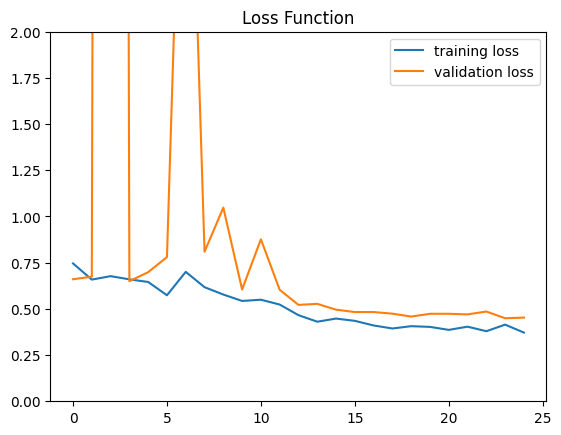

In [91]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'Precision Function')

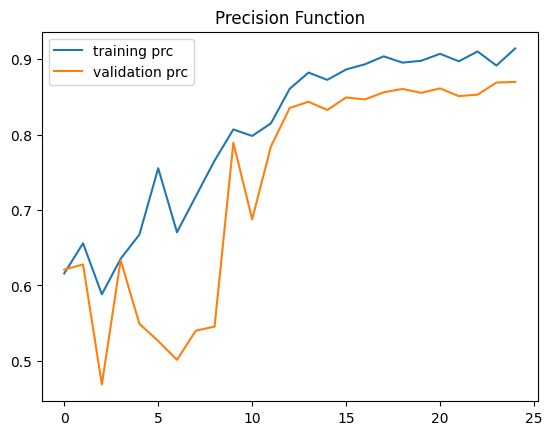

In [92]:
plt.plot(training_score['prc'], label='training prc')

plt.plot(training_score['val_prc'], label='validation prc')
plt.legend()
plt.title('Precision Function')

Text(0.5, 1.0, 'AUC Function')

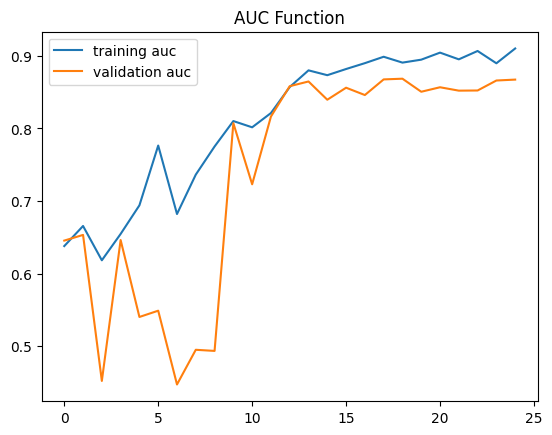

In [93]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')

In [94]:
  model.save(saved_model_path)